# Libs and pre-definitions

In [1]:
import os
REPOSITORY_PATH = r'/home/luis-felipe/UncEst'
DATA_PATH = os.path.join(REPOSITORY_PATH,'data')
#CORRUPTED_DATA_PATH = os.path.join(DATA_PATH,'corrupted')

PATH_MODELS = os.path.join(REPOSITORY_PATH,'torch_models')
PATH_TRAINER = os.path.join(PATH_MODELS,'trainer')

PATH_FIGS = os.path.join(REPOSITORY_PATH,'figs','MCBatchNormalization')

### Bibliotecas padrões python e utils pytorch

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from collections import defaultdict
import random

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

True


### Bibliotecas desenvolvidas

https://github.com/lfpc/Uncertainty_Estimation

In [4]:
import NN_models as models
import NN_utils as utils
import NN_utils.train_and_eval as TE
import torch_data

In [5]:
import uncertainty.metrics as metrics
from uncertainty.MCBN import MonteCarloBatchNormalization as MCBN

# Analysis

## Definitions

In [6]:
MODEL_ARC = 'VGG_16'
DATA = 'Cifar100'
NAME = MODEL_ARC +'_' + DATA + '_MCBN'

data = torch_data.__dict__[DATA](data_dir = DATA_PATH)
model_class = models.__dict__[MODEL_ARC]

weights_path = os.path.join(PATH_MODELS,MODEL_ARC,DATA)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
WEIGTH_FILE = 0
N_ENS = 10

## Upload Models

In [8]:
def weights_files(weights_path):
    #Get all weight files in weights_path
    files = [f for f in os.listdir(weights_path) if os.path.isfile(os.path.join(weights_path, f)) and f.endswith(".pt")]
    files = sorted(files)
    return files

def upload_weights(file, weights_path):
    files = weights_files(weights_path)

    if isinstance(file,int):
        weights = files[file]
        weights = os.path.join(weights_path,weights)
    elif file == 'random':
        weights = random.choice(files)
        weights = os.path.join(weights_path,weights)
    elif file == 'max':
        return upload_weights(0, weights_path)
    elif isinstance(file,str):
        if file in files:
            weights = os.path.join(weights_path,file)
        elif file+'.pt' in files:
            weights = os.path.join(weights_path,file+'.pt')
        else: raise Exception("No file named ", file)
    state_dict = torch.load(weights)
    return state_dict


In [9]:
model = model_class(num_classes = data.n_classes,softmax = True).to(dev)
model.eval()
model.load_state_dict(upload_weights(WEIGTH_FILE, weights_path))
print(f'Acurácia (modelo determinístico): {TE.model_acc(model,data.test_dataloader)}')

Acurácia (modelo determinístico): 72.49


In [10]:
model_mcbn = MCBN(model,N_ENS, data.train_dataloader,as_ensemble= True).to(dev)
print(f'Acurácia (com MCBN): {TE.model_acc(model_mcbn,data.test_dataloader, set_eval = False)}')

Acurácia (com MCBN): 73.26


## Plots

### Deterministic Inference

#### Risk x Coverage

In [11]:
model_mcbn_det = MCBN(model,N_ENS, data.train_dataloader,as_ensemble= False).to(dev)

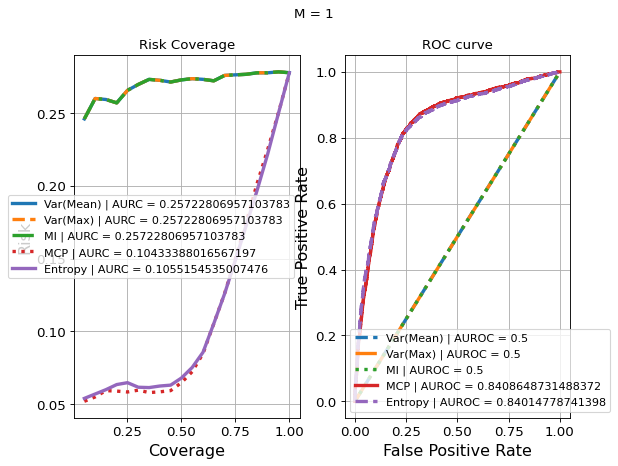

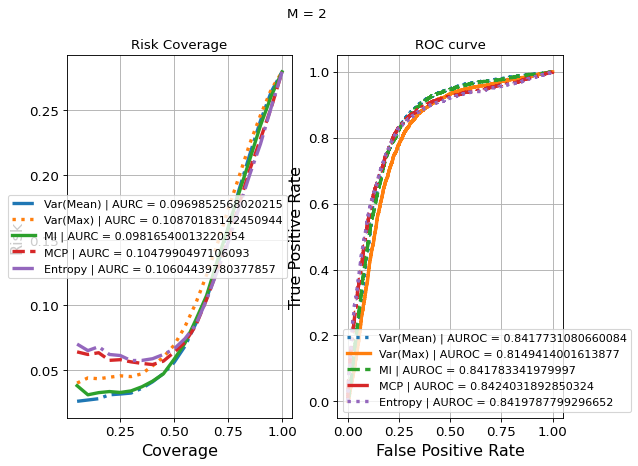

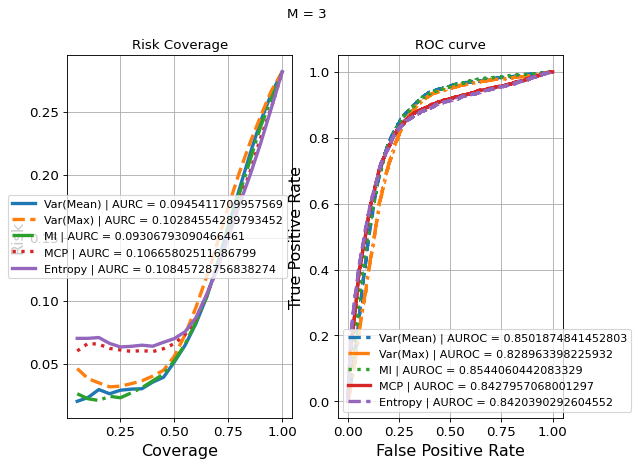

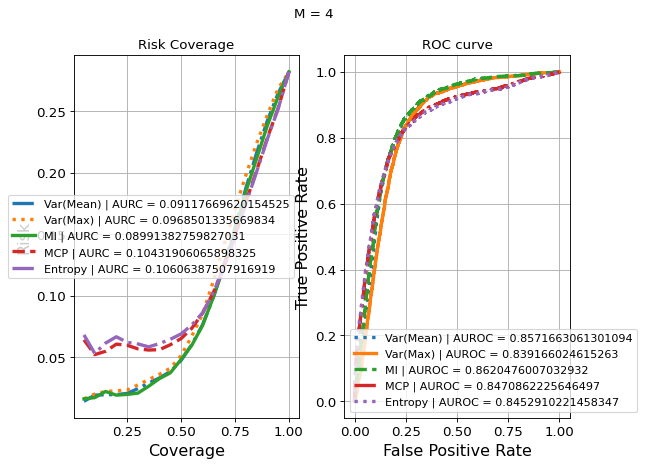

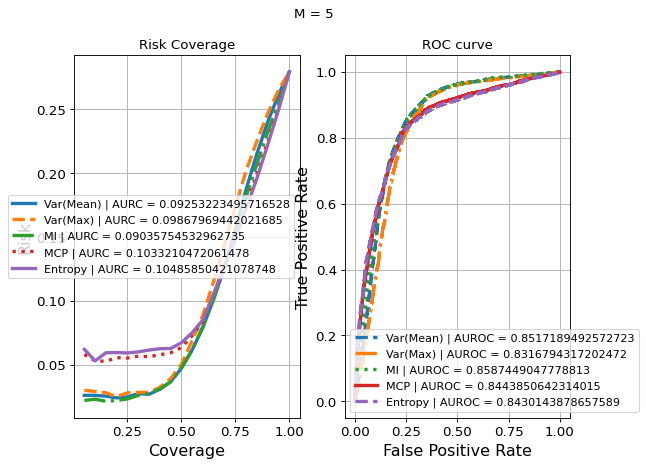

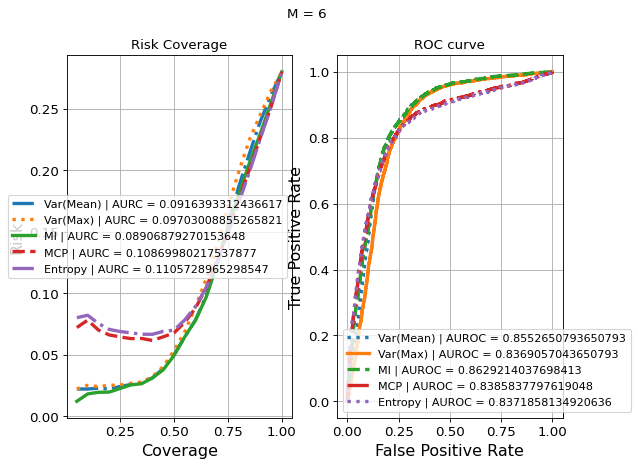

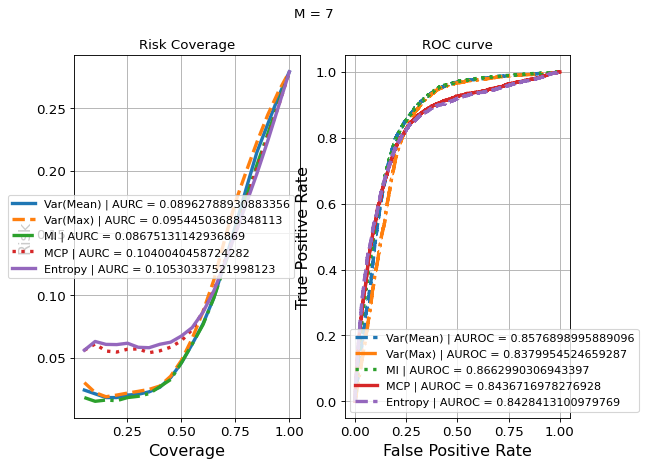

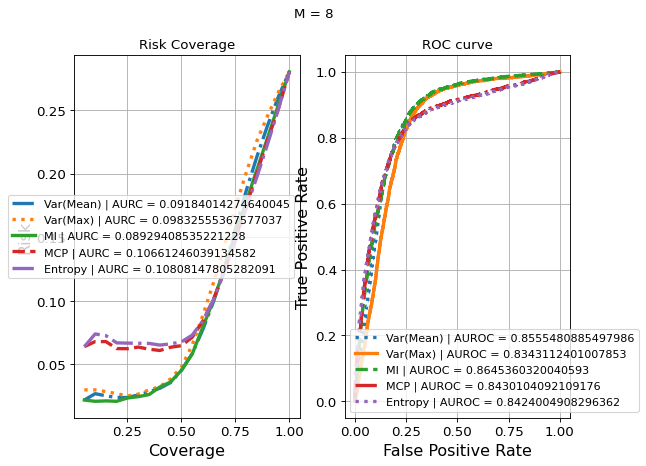

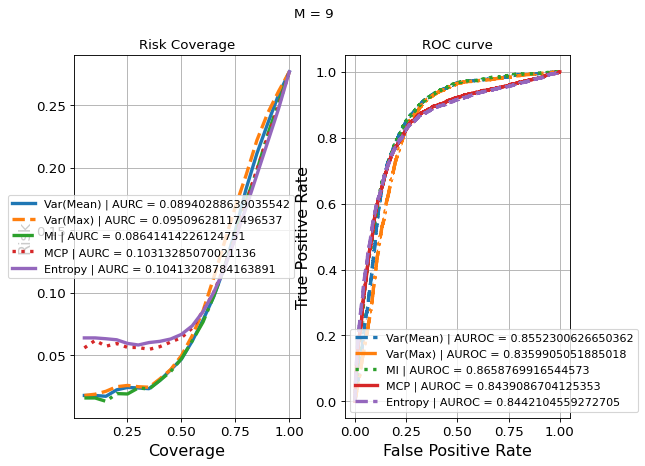

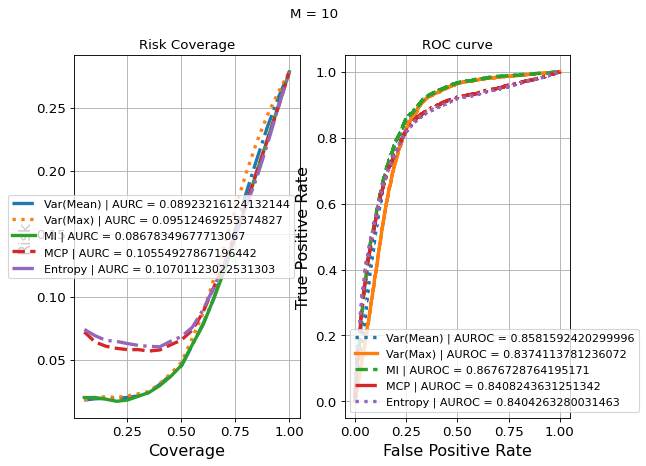

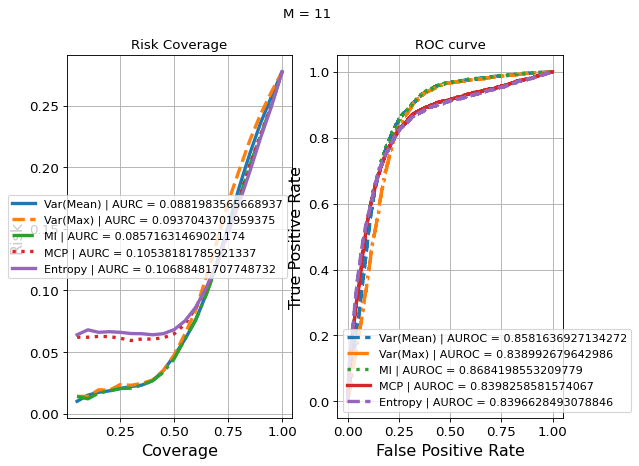

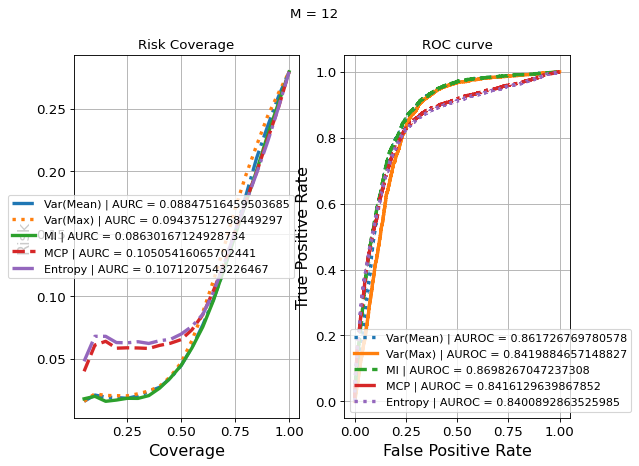

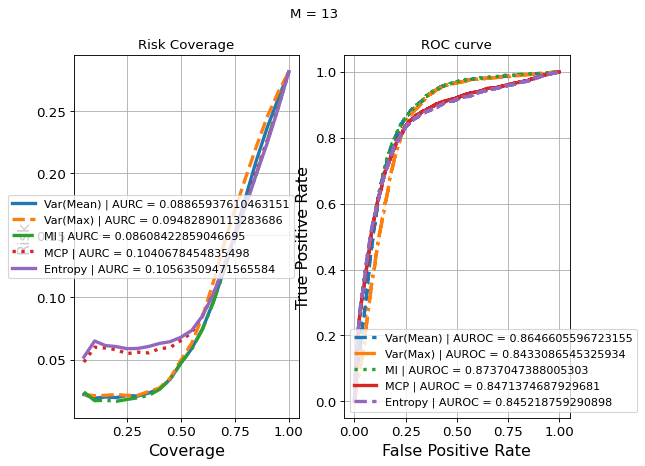

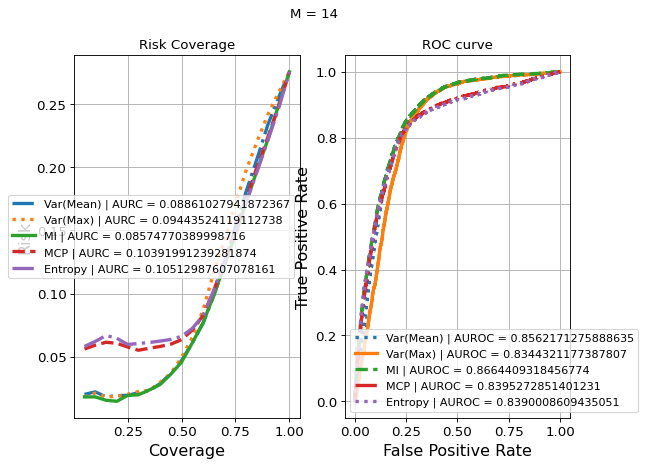

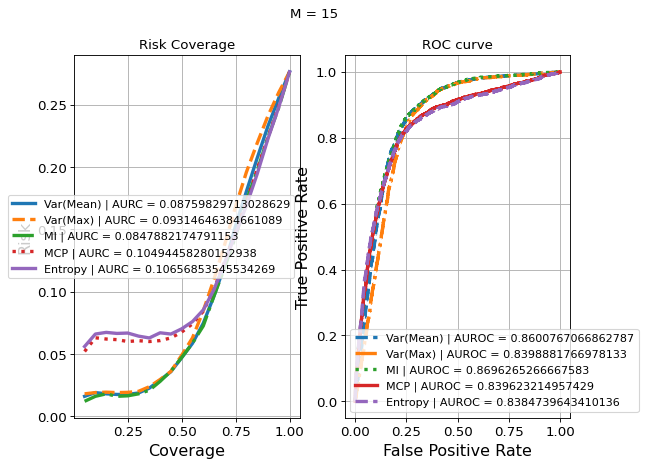

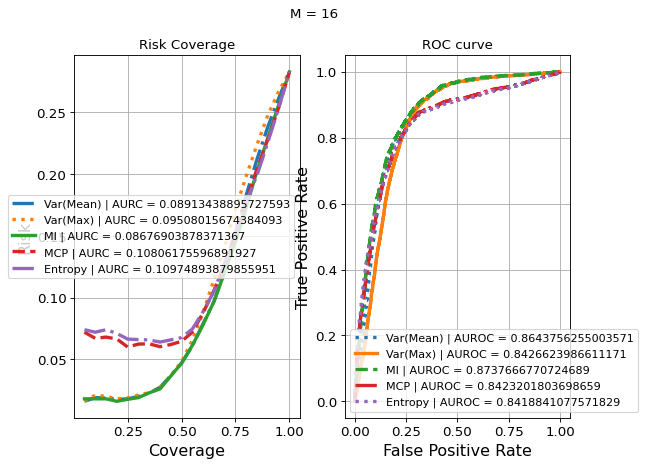

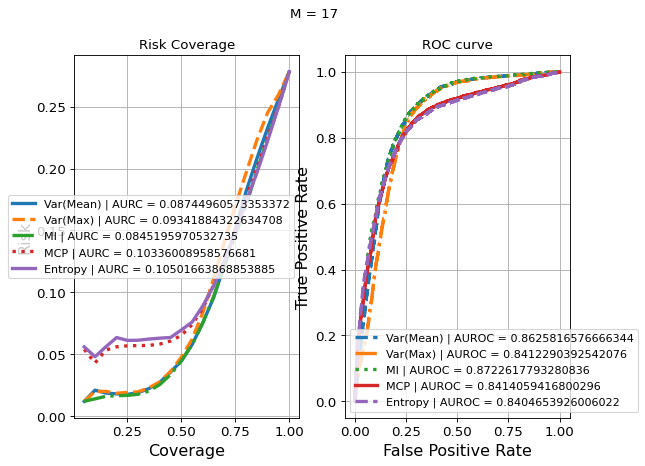

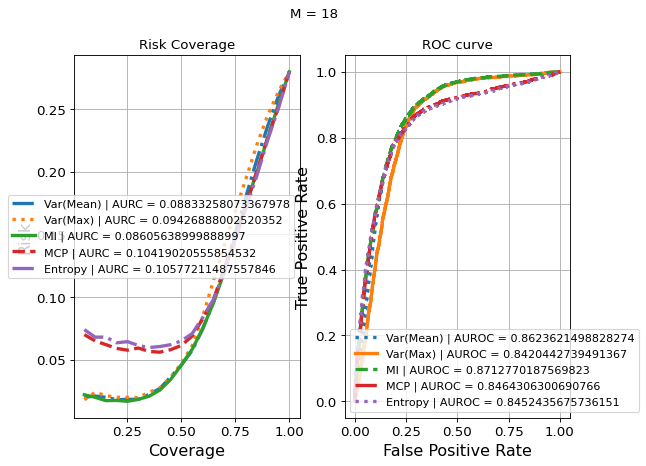

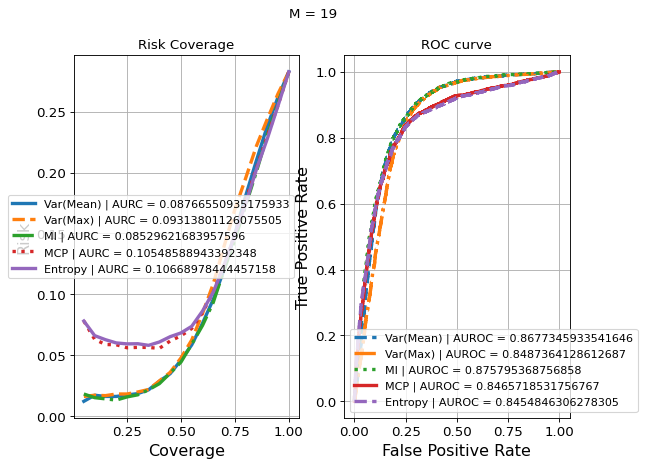

In [12]:
RC = metrics.selective_metrics(model_mcbn_det,None)
for N_ENS in range(1,20):
    model_mcbn_det.n_samples = N_ENS
    RC.get_uncs(data.test_dataloader)
    RC.plot_ROC_and_RC(aurc = True)
    plt.suptitle(f'M = {N_ENS}')
    plt.show()

#### Risk x M

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


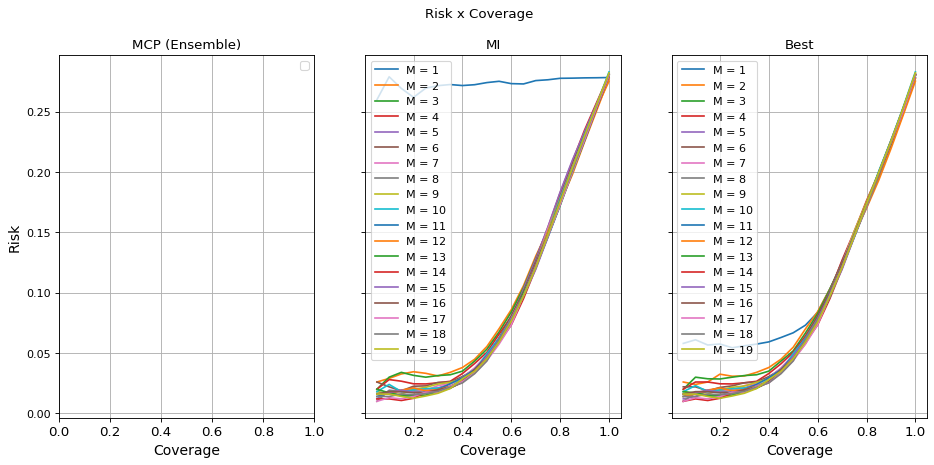

In [13]:
uncs = ['MCP (Ensemble)','MI','Best']
#RC.set_uncs(uncs)
f, axes = plt.subplots(1, len(uncs),sharey = True,figsize=(14,6),dpi=80)
for N_ENS in range(1,20):
    model_mcbn_det.n_samples = N_ENS
    RC.get_uncs(data.test_dataloader)
    RC.RC_curves()
    for i,unc in enumerate(uncs):
        if unc in RC.risk.keys():
            axes[i].plot(RC.c_list,RC.risk[unc],label = f'M = {N_ENS}')
        elif unc == 'Best':
            axes[i].plot(RC.c_list,RC.get_best(),label = f'M = {N_ENS}')
        else:
            continue
for i,unc in enumerate(uncs):
    axes[i].set_title(uncs[i])
    axes[i].set_xlabel("Coverage", fontsize=RC.LABEL_FONTSIZE*0.7)
    axes[i].tick_params(axis="x",labelsize=RC.TICKS_FONTSIZE)
    axes[i].grid()
    axes[i].legend()
axes[0].set_ylabel("Risk", fontsize=RC.LABEL_FONTSIZE*0.7)
plt.suptitle(f'Risk x Coverage')
plt.show()

#### ROC x M

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


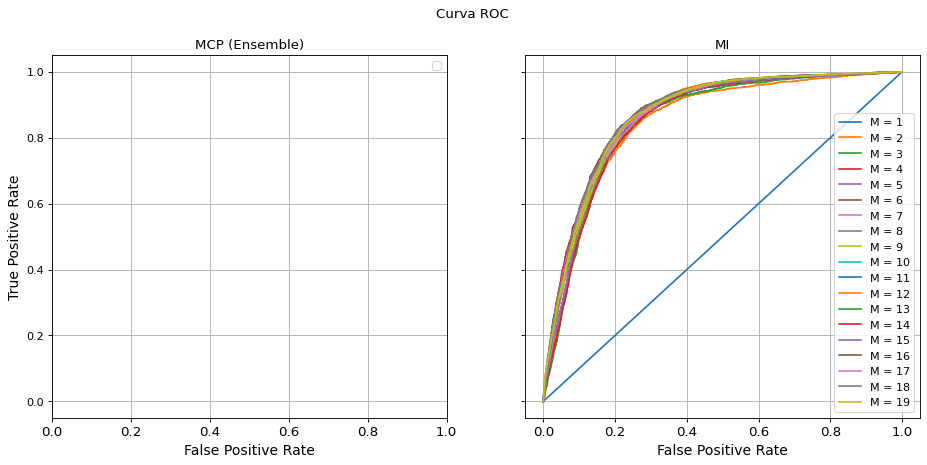

In [14]:
uncs = ['MCP (Ensemble)','MI']
#RC.set_uncs(uncs)
f, axes = plt.subplots(1, len(uncs),sharey = True,figsize=(14,6),dpi=80)
for N_ENS in range(1,20):
    model_mcbn_det.n_samples = N_ENS
    RC.get_uncs(data.test_dataloader)
    RC.ROC_curves()
    for i,unc in enumerate(uncs):
        if unc in RC.risk.keys():
            axes[i].plot(RC.ROC[unc][0],RC.ROC[unc][1],label = f'M = {N_ENS}')
        else: continue
for i,unc in enumerate(uncs):
    axes[i].set_title(uncs[i])
    axes[i].set_xlabel("False Positive Rate", fontsize=RC.LABEL_FONTSIZE*0.7)
    axes[i].tick_params(axis="x",labelsize=RC.TICKS_FONTSIZE)
    axes[i].grid()
    axes[i].legend()
axes[0].set_ylabel("True Positive Rate", fontsize=RC.LABEL_FONTSIZE*0.7)
plt.suptitle(f'Curva ROC')
plt.show()

### Ensemble (average)

#### Risk x Coverage

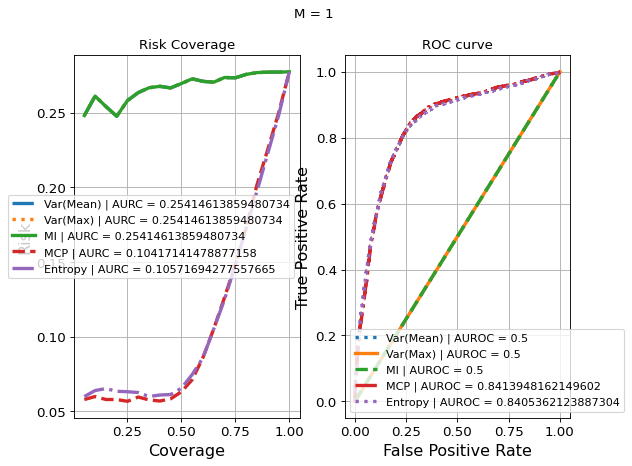

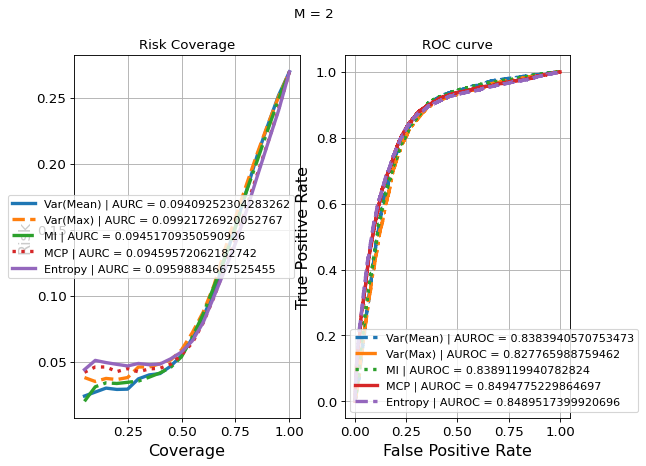

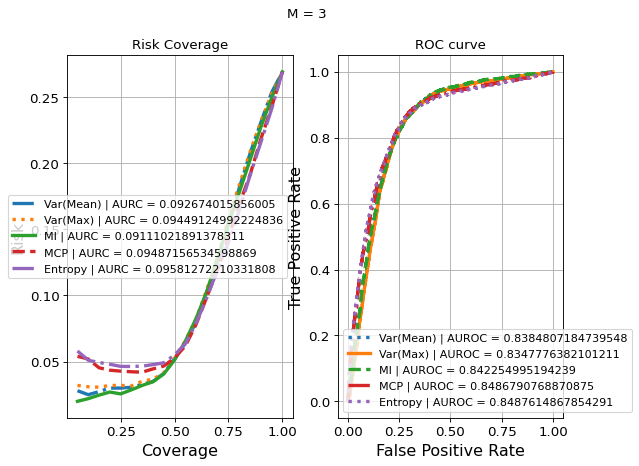

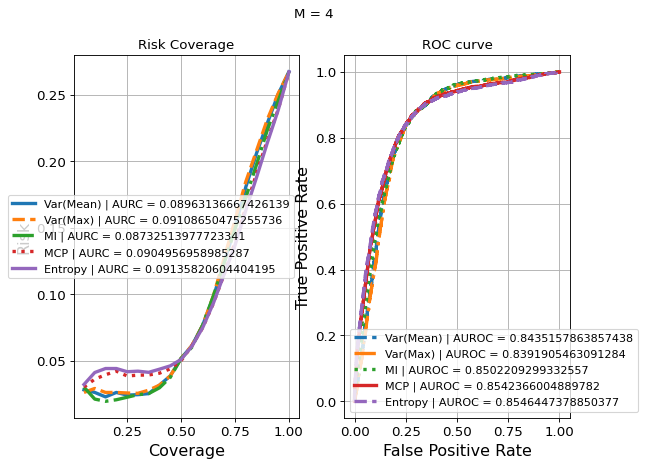

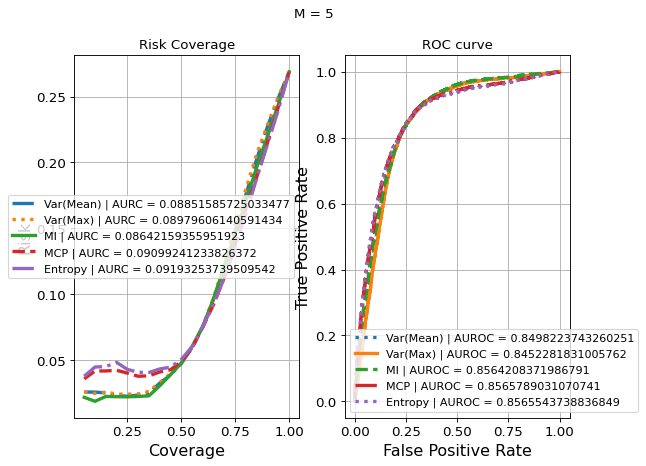

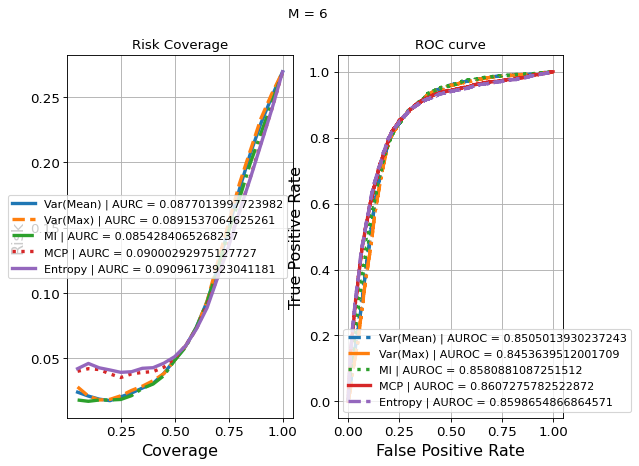

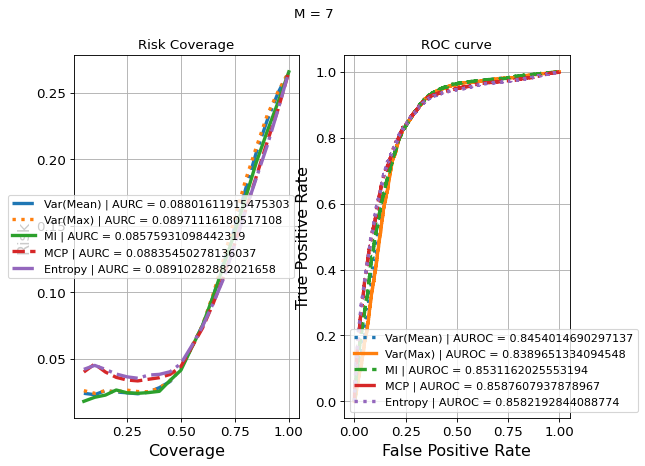

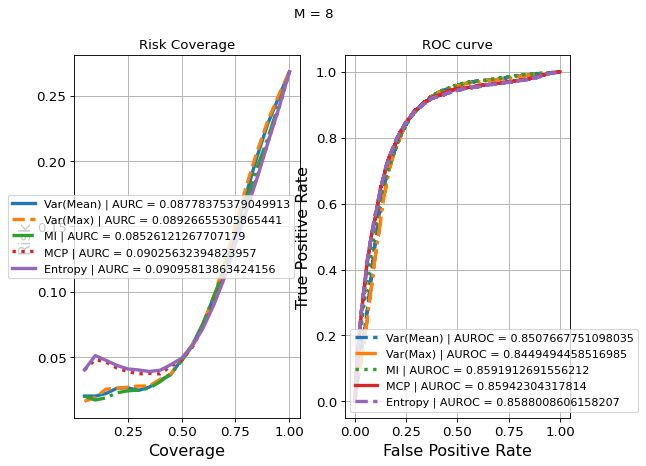

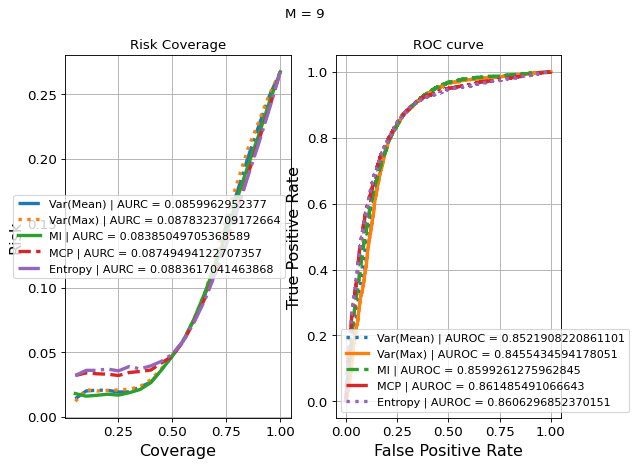

Traceback (most recent call last):


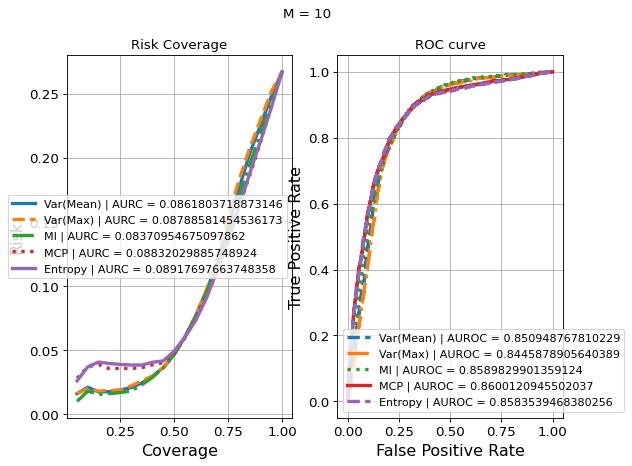

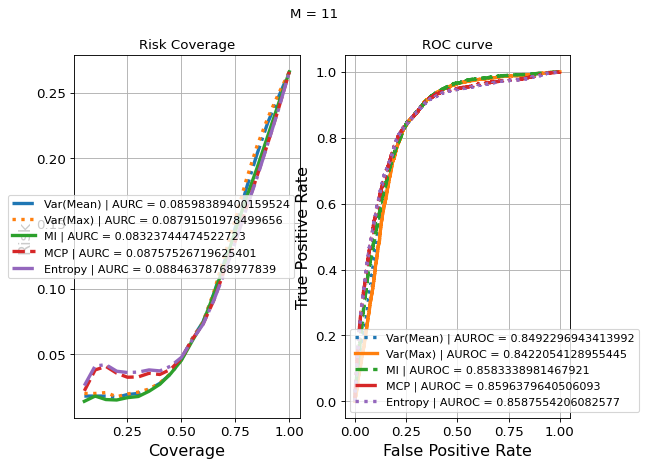

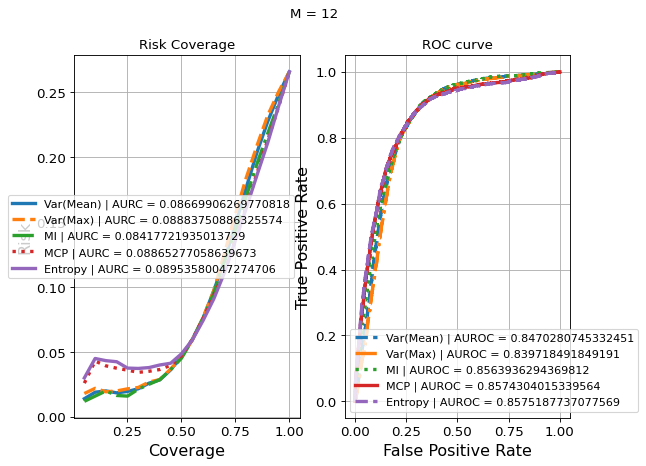

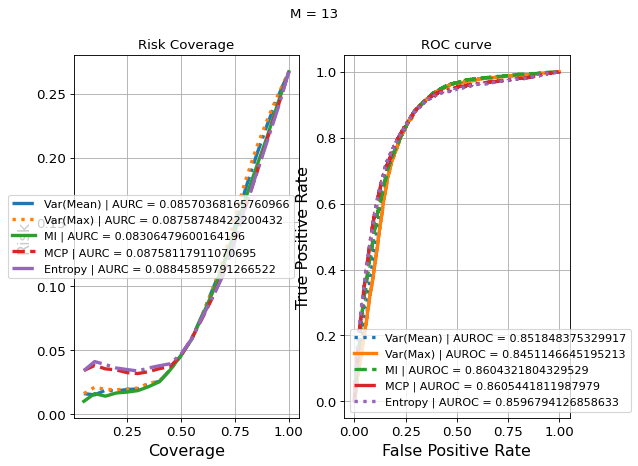

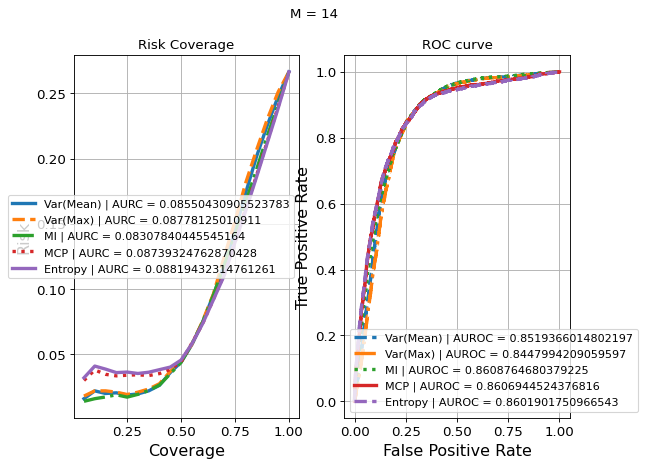

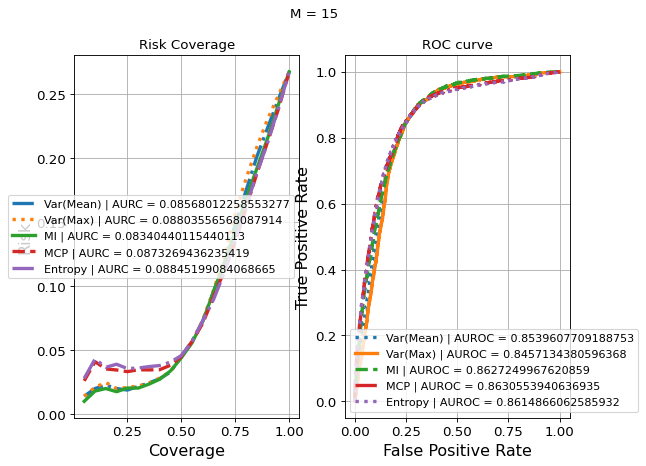

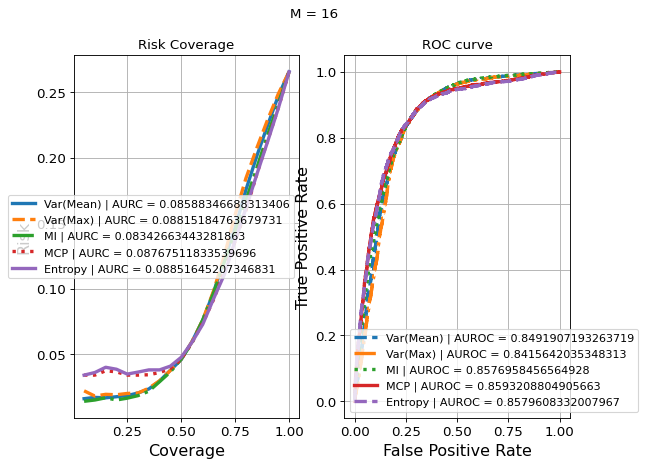

Traceback (most recent call last):


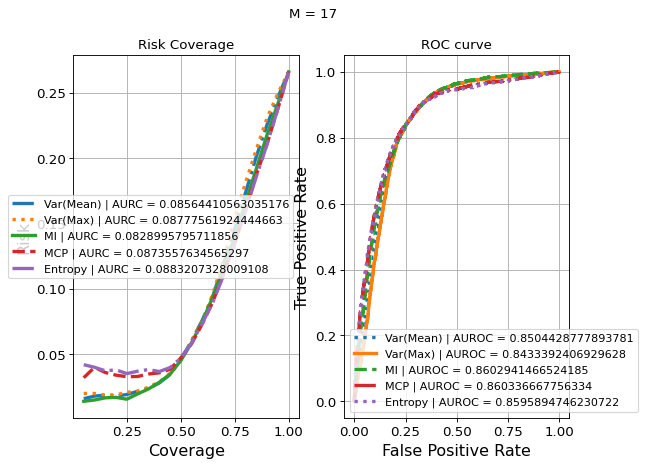

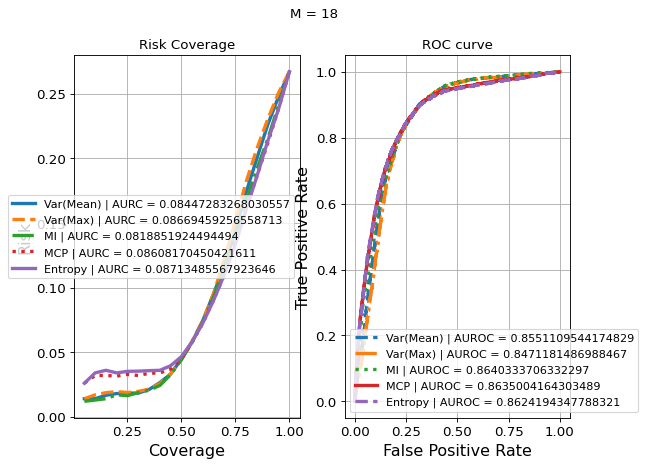

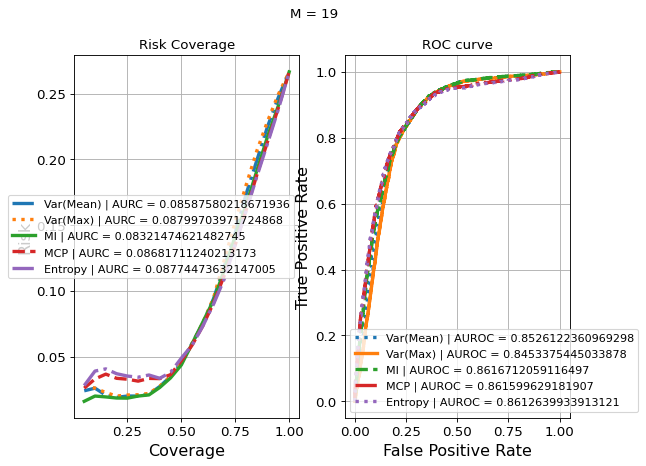

In [15]:
RC_dict = {}
for N_ENS in range(1,20):
    model_mcbn.n_samples = N_ENS
    RC = metrics.selective_metrics(model_mcbn,data.test_dataloader,labels = RC.label)
    RC.plot_ROC_and_RC(aurc = True)
    RC_dict[N_ENS] = RC
    plt.suptitle(f'M = {N_ENS}')
    plt.show()

#### Risk x M

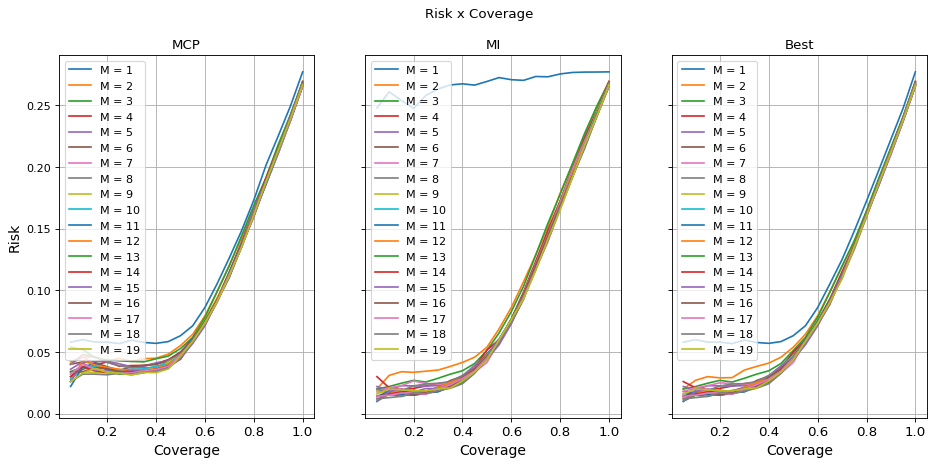

In [16]:
uncs = ['MCP','MI','Best']
#RC.set_uncs(uncs)
f, axes = plt.subplots(1, len(uncs),sharey = True,figsize=(14,6),dpi=80)
for N_ENS,RC in RC_dict.items():
    for i,unc in enumerate(uncs):
        if unc in RC.risk.keys():
            axes[i].plot(RC.c_list,RC.risk[unc],label = f'M = {N_ENS}')
        elif unc == 'Best':
            axes[i].plot(RC.c_list,RC.get_best(),label = f'M = {N_ENS}')
        else:
            continue
for i,unc in enumerate(uncs):
    axes[i].set_title(uncs[i])
    axes[i].set_xlabel("Coverage", fontsize=RC.LABEL_FONTSIZE*0.7)
    axes[i].tick_params(axis="x",labelsize=RC.TICKS_FONTSIZE)
    axes[i].grid()
    axes[i].legend()
axes[0].set_ylabel("Risk", fontsize=RC.LABEL_FONTSIZE*0.7)
plt.suptitle(f'Risk x Coverage')
plt.show()

#### ROC x M

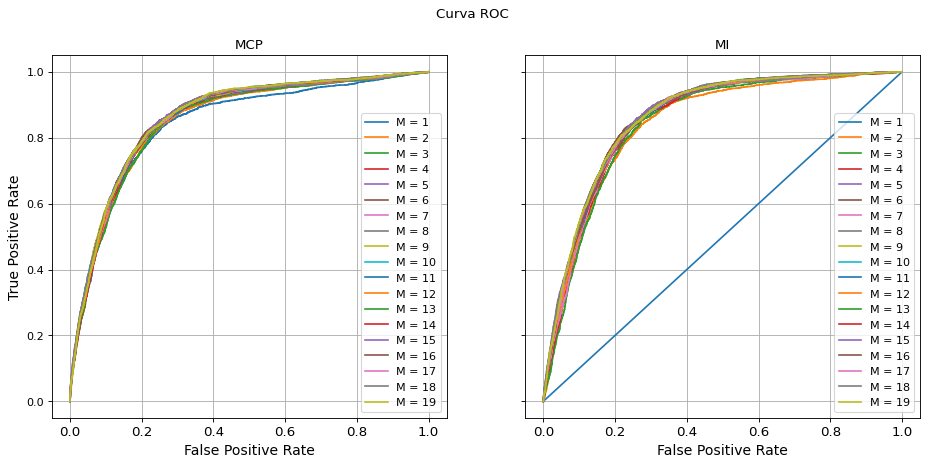

In [17]:
uncs = ['MCP','MI']
#RC.set_uncs(uncs)
f, axes = plt.subplots(1, len(uncs),sharey = True,figsize=(14,6),dpi=80)
for N_ENS,RC in RC_dict.items():
    for i,unc in enumerate(uncs):
        if unc in RC.risk.keys():
            axes[i].plot(RC.ROC[unc][0],RC.ROC[unc][1],label = f'M = {N_ENS}')
        else: continue
for i,unc in enumerate(uncs):
    axes[i].set_title(uncs[i])
    axes[i].set_xlabel("False Positive Rate", fontsize=RC.LABEL_FONTSIZE*0.7)
    axes[i].tick_params(axis="x",labelsize=RC.TICKS_FONTSIZE)
    axes[i].grid()
    axes[i].legend()
axes[0].set_ylabel("True Positive Rate", fontsize=RC.LABEL_FONTSIZE*0.7)
plt.suptitle(f'Curva ROC')
plt.show()

### Ensemble x Deterministic Inference

#### RC

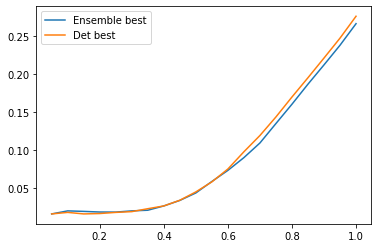

In [18]:
N_ENS = 19
RC = RC_dict[N_ENS]#for N_ENS,RC in RC_dict.items():
model_mcbn_det.n_samples = N_ENS
RC_det = metrics.selective_metrics(model_mcbn_det,data.test_dataloader,labels = RC.label)
RC_det.RC_curves()
#RC.plot_RC(aurc = True)
plt.plot(RC.c_list,RC.get_best(),label = f'Ensemble best')
plt.plot(RC_det.c_list,RC_det.get_best(),label = f'Det best')
plt.legend()
plt.show()

In [19]:
#det retira melhor a incerteza, porém só pq tem mais erros!